In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [02:52<00:00, 18.9MB/s]
100% 3.24G/3.24G [02:52<00:00, 20.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [6]:
# Define the directory containing the dataset
image_dir = Path('/content/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convert filepaths and labels to pandas Series
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

# Sample 500 images from each class
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(500, random_state=1))

# Combine sampled images into a single DataFrame and shuffle
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Display the DataFrame
image_df.head()

,Filepath,Label
0,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet
1,/content/Fish_Dataset/Fish_Dataset/Trout/Trout...,Trout
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
4,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [8]:
print("Training DataFrame:")
train_df.head()

Training DataFrame:


,Filepath,Label
2031,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
2276,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
2113,/content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...,Shrimp
2687,/content/Fish_Dataset/Fish_Dataset/Trout/Trout...,Trout
734,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet


In [9]:
print("\nTesting DataFrame:")
test_df.head()


Testing DataFrame:


,Filepath,Label
2909,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
1546,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet
62,/content/Fish_Dataset/Fish_Dataset/Trout/Trout...,Trout
44,/content/Fish_Dataset/Fish_Dataset/Red Sea Bre...,Red Sea Bream
1237,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 2520 validated image filenames belonging to 9 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 630 validated image filenames belonging to 9 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1350 validated image filenames belonging to 9 classes.


tf.keras.applications.MobileNetV2: This function loads the MobileNetV2 model architecture pretrained on the ImageNet dataset.

In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
inputs = pretrained_model.input

In [16]:
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

This compiles the model, setting the optimizer to Adam, the loss function to categorical crossentropy (suitable for multiclass classification), and the metric to track during training as accuracy

In [18]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
79/79 [==============================] - 51s 545ms/step - loss: 0.4040 - accuracy: 0.8893 - val_loss: 0.0789 - val_accuracy: 0.9762
Epoch 2/10
79/79 [==============================] - 33s 422ms/step - loss: 0.0256 - accuracy: 0.9956 - val_loss: 0.0262 - val_accuracy: 0.9937
Epoch 3/10
79/79 [==============================] - 32s 405ms/step - loss: 0.0085 - accuracy: 0.9996 - val_loss: 0.0209 - val_accuracy: 0.9937
Epoch 4/10
79/79 [==============================] - 36s 463ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0140 - val_accuracy: 0.9937
Epoch 5/10
79/79 [==============================] - 34s 427ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9952
Epoch 6/10
79/79 [==============================] - 33s 412ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9968
Epoch 7/10
79/79 [==============================] - 37s 465ms/step - loss: 9.1957e-04 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


predictions = model.predict(test_images)
y_true = test_images.classes
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(y_true, predictions, average='weighted', multi_class='ovr')

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)


43/43 [==============================] - 20s 437ms/step
Confusion Matrix:
 [[148   0   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0   0]
 [  0   0 161   0   0   0   0   0   0]
 [  0   0   0 141   0   0   0   0   0]
 [  0   0   0   0 151   0   0   0   0]
 [  0   0   0   0   0 140   0   0   1]
 [  0   0   0   0   0   0 163   0   0]
 [  0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   1   0   0 148]]
F1 Score: 0.9985185185185185
ROC AUC Score: 0.9999975410824793


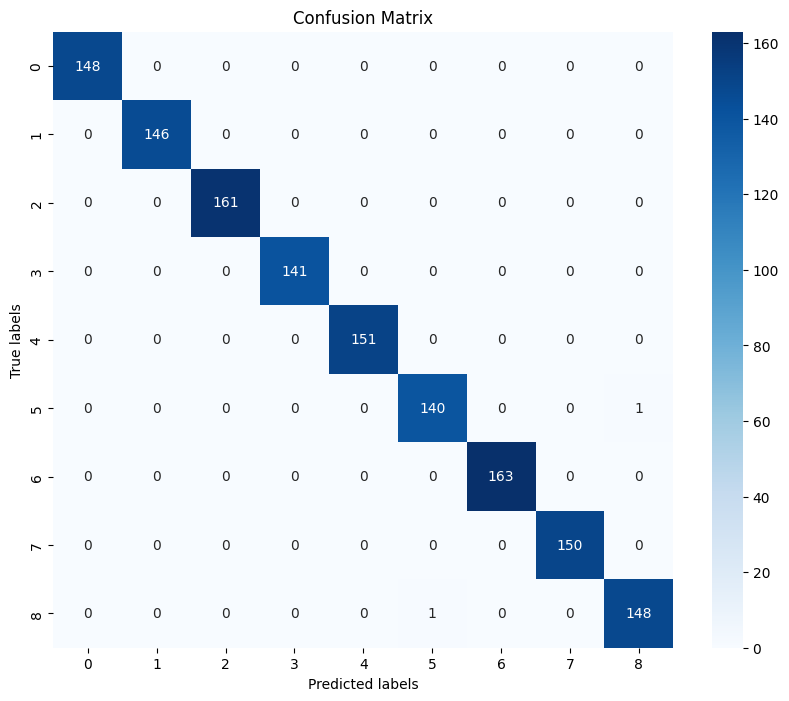

In [20]:
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

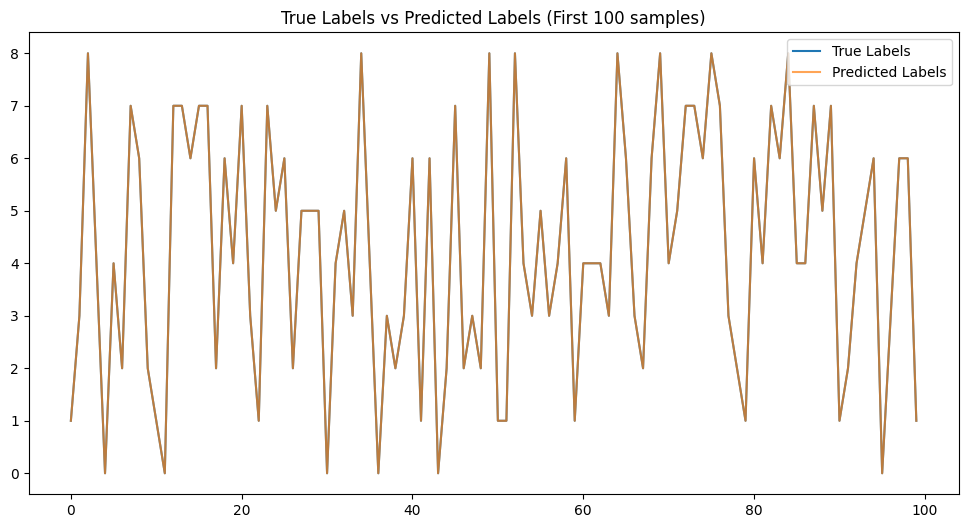

In [21]:
# Plot y_true vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(y_true[:100], label="True Labels")
plt.plot(y_pred[:100], label="Predicted Labels", alpha=0.7)
plt.legend()
plt.title('True Labels vs Predicted Labels (First 100 samples)')
plt.show()

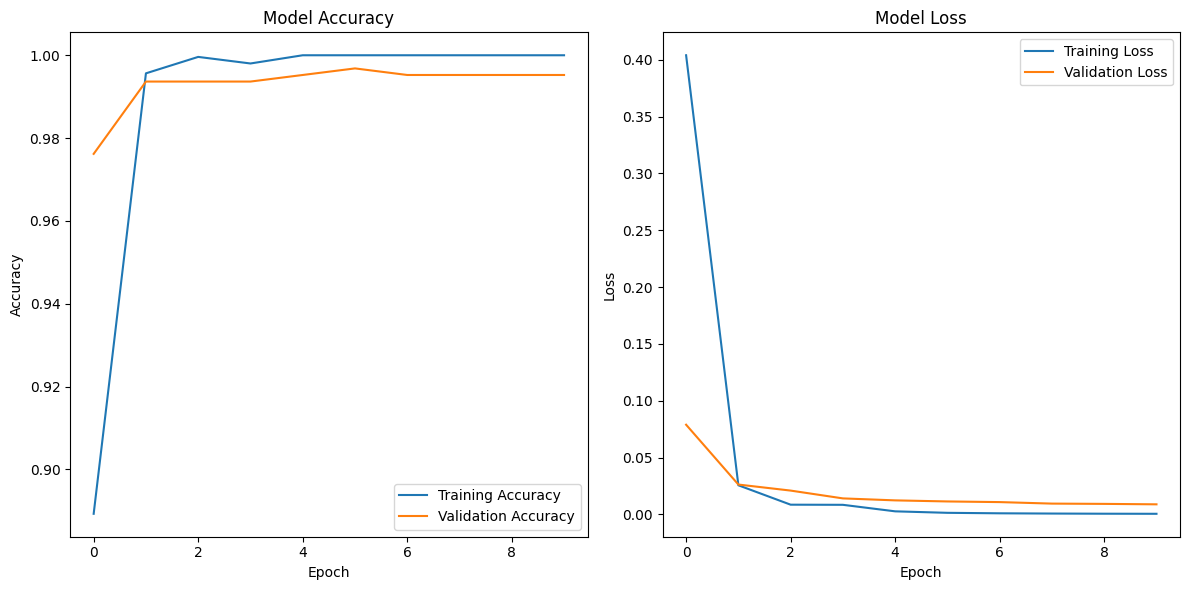

In [22]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

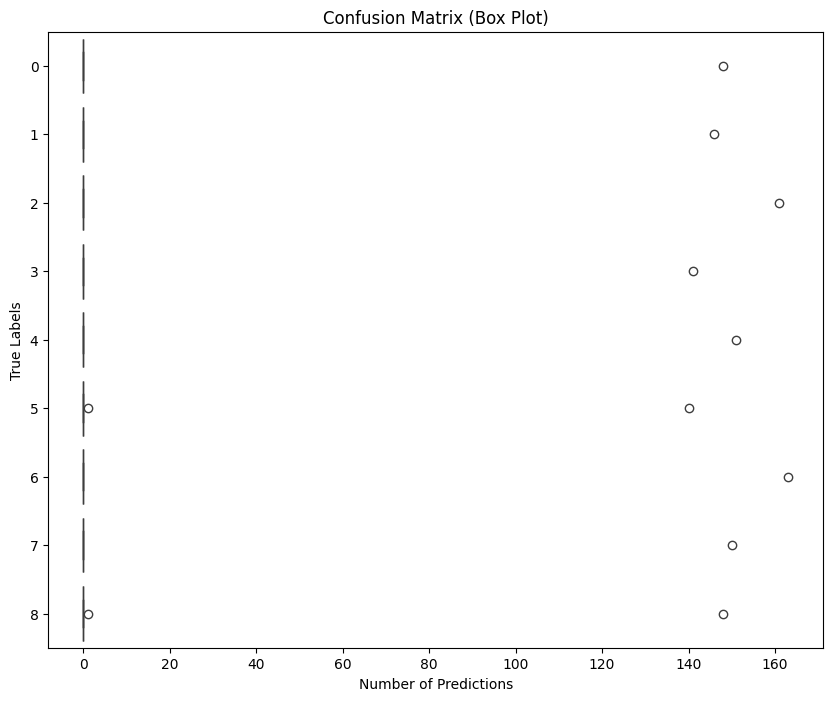

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(9), columns=range(9))

# Plot confusion matrix as a box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=conf_matrix_df, orient='h')
plt.xlabel('Number of Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Box Plot)')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix as matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[148   0   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0   0]
 [  0   0 161   0   0   0   0   0   0]
 [  0   0   0 141   0   0   0   0   0]
 [  0   0   0   0 151   0   0   0   0]
 [  0   0   0   0   0 140   0   0   1]
 [  0   0   0   0   0   0 163   0   0]
 [  0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   1   0   0 148]]
